In [54]:
#| default_exp tfsm/mip

In [55]:
#| export 
import math
import numpy as np 
import fastcore.all as fc

from voxdet.tfsm.standard import BaseT

In [56]:
from voxdet.utils import vis

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Maximum Intensity Projection

In [58]:
import SimpleITK as sitk 
img = sitk.ReadImage("/home/users/shubham.kumar/projects/qct_nodule_detection/resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785.nii.gz")
img.GetSpacing(), img.GetSize()

((0.5789999961853027, 0.5789999961853027, 3.0), (512, 512, 90))

In [59]:
fimg = sitk.GetArrayFromImage(img)
spacing = img.GetSpacing()[::-1]
fimg.shape, spacing

((90, 512, 512), (3.0, 0.5789999961853027, 0.5789999961853027))

In [60]:
# test scan
exp = {
    "images": fimg,
    "boxes": np.asarray([[10., 10., 10., 20., 20., 20.]]),
    "series_id": "1.3.6.1.4.1.14519.5.2.1.6279.6001.309564220265302089123180126785",
    "spacing": spacing
}

In [80]:
#| export
def get_mip_array(img, stride:int=1, num_slices:int=5, mode:str="max"):
    assert img.ndim == 3 or 4, f"Expected NumPy array to have 3 or 4 dims. Got shape {img.shape}"
    
    func = {"max": np.amax, "min": np.amin, "mean": np.mean}
    if mode not in func:
        raise NotImplementedError

    slices_per_mip = []
    
    n_mip_slices = math.ceil(img.shape[0]/stride)
    np_mip = np.empty((n_mip_slices, img.shape[1], img.shape[2]), img.dtype)

    # can we vectorize this further?
    for i in range(n_mip_slices):
        start = i*stride
        
        end = min(start+num_slices, img.shape[0])
        np_mip[i] = func[mode](img[start:end], 0)
        slices_per_mip.append(end - start)

    return np_mip.astype(np.float64)

In [62]:
%%time
img = exp["images"]
mip = get_mip_array(img)

CPU times: user 13.1 ms, sys: 20.4 ms, total: 33.5 ms
Wall time: 32.9 ms


In [63]:
%%time
stacked = np.stack((img, mip), axis=0)
stacked.shape

CPU times: user 9.56 ms, sys: 31.4 ms, total: 41 ms
Wall time: 40.3 ms


(2, 90, 512, 512)

In [64]:
#| export
class MIP(BaseT):
    def __init__(self, num_slices: int = 5, stride: int = 1, mode:str = "max", return_stacked_img:bool = True, mip_channel:int = 0 ):
        """create MIP numpy array from given image numpy array"""
        fc.store_attr()
        super().__init__()
    __repr__ = fc.basic_repr(flds="num_slices, mode, stride, return_stacked_img, mip_channel")
    
    def apply(self, img: dict):
        assert all([i in list(img.keys()) for i in ["images"]])
        fimg, nimg = img["images"], {}
        nimg["images"] = self.apply_image(fimg)
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
    
    def apply_image(self, img: np.asarray):
        if img.ndim == 3 :
            mip = get_mip_array(img, stride=self.stride, num_slices=self.num_slices, mode=self.mode)
            stacked_img = np.stack((img, mip), axis=0)
        if img.ndim == 4 :
            mips = []
            for ch in self.mip_channel : 
                mip = get_mip_array(img[ch], stride=self.stride, num_slices=self.num_slices, mode=self.mode)
                mips.append(mip)
            mips = np.stack(mips, axis = 0)
            stacked_img = np.concatenate((img, mips), axis=0)
        
        if self.return_stacked_img: return stacked_img
        return mip
        
    def reverse_apply(self, img: dict): return img

In [65]:
mip = MIP(num_slices=5, stride=1, mode="max", return_stacked_img=False)
mip

__main__.MIP(num_slices=5, mode='max', stride=1, return_stacked_img=False)

In [66]:
%%time
out = mip(exp)

CPU times: user 17.4 ms, sys: 12.5 ms, total: 29.9 ms
Wall time: 29.3 ms


In [67]:
exp["images"].shape, out["images"].shape

((90, 512, 512), (90, 512, 512))

In [68]:
assert fc.all_equal(exp["boxes"], out["boxes"]), "MIP should not affect bboxes"
assert fc.all_equal(exp["images"].shape[1:], out["images"].shape[1:]), "MIP should not affect slice sizes"

In [69]:
out["images"].max(), out["images"].mean(), out["images"].min()

(2499.0, -638.8184280395508, -2048.0)

In [70]:
np.unique(out["images"]), np.unique(out["images"]).shape

(array([-2048., -1030., -1029., ...,  2494.,  2495.,  2499.]), (3247,))

Text(0, 0.5, 'Frequency')

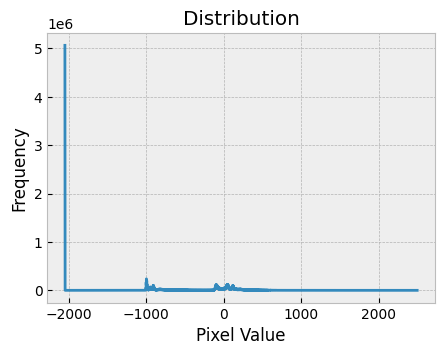

In [71]:
import matplotlib.pyplot as plt
plt.style.use("bmh")

histogram, bin_edges = np.histogram(out["images"], bins=np.unique(out["images"]).shape[0])

plt.figure(figsize=(5, 3.5))
plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.title("Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

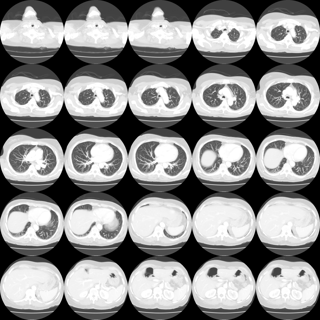

In [72]:
vis(out["images"], 64, window=True)

In [73]:
mip = MIP(num_slices=5, stride=1, mode="mean", return_stacked_img=False)

In [74]:
%%time
out = mip(exp)

CPU times: user 52.9 ms, sys: 20.2 ms, total: 73.1 ms
Wall time: 72.6 ms


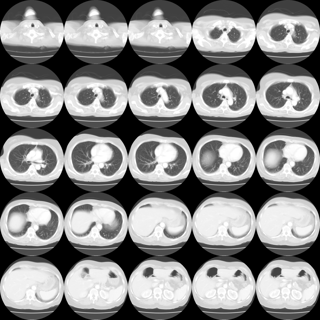

In [75]:
vis(out["images"], 64, window=True)

In [76]:
mip = MIP(num_slices=5, stride=1, mode="min", return_stacked_img=False)

In [77]:
%%time
out = mip(exp)

CPU times: user 3.09 ms, sys: 27.9 ms, total: 31 ms
Wall time: 30.4 ms


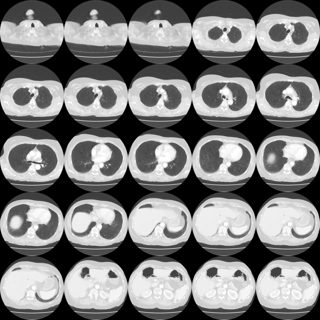

In [78]:
vis(out["images"], 64, window=True)

In [79]:
#| hide
import nbdev; nbdev.nbdev_export()

JSONDecodeError: Expecting ',' delimiter: line 44 column 1 (char 971)